# Import Library

In [1]:
import pandas as pd 
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import numpy as np

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error
import warnings
warnings.filterwarnings("ignore")

# Data Loading

In [2]:
df = pd.read_csv('gender_classification_v7.csv')
df.head().T

,0,1,2,3,4
long_hair,1,0,0,0,1
forehead_width_cm,11.8,14.0,11.8,14.4,13.5
forehead_height_cm,6.1,5.4,6.3,6.1,5.9
nose_wide,1,0,1,0,0
nose_long,0,0,1,1,0
lips_thin,1,1,1,1,0
distance_nose_to_lip_long,1,0,1,1,0
gender,Male,Female,Male,Male,Female


In [3]:
feature_cols = list(df.select_dtypes('number'))
num_cols = ['forehead_width_cm','forehead_height_cm']
cat_cols = list(df.select_dtypes(object))

In [4]:
feature_cols

['long_hair',
 'forehead_width_cm',
 'forehead_height_cm',
 'nose_wide',
 'nose_long',
 'lips_thin',
 'distance_nose_to_lip_long']

In [5]:
cat_cols

['gender']

# Cleaning Data

In [6]:
df.isnull().any()

long_hair                    False
forehead_width_cm            False
forehead_height_cm           False
nose_wide                    False
nose_long                    False
lips_thin                    False
distance_nose_to_lip_long    False
gender                       False
dtype: bool

Tidak ada missing value

In [7]:
df.duplicated().any()

True

In [8]:
df = df.drop_duplicates()

In [9]:
df.duplicated().any()

False

Membuang data duplikat pada dataset

# EDA

In [10]:
df[feature_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
long_hair,3233.0,0.822456,0.382188,0.0,1.0,1.0,1.0,1.0
forehead_width_cm,3233.0,13.217198,1.115993,11.4,12.3,13.2,14.1,15.5
forehead_height_cm,3233.0,5.966038,0.549789,5.1,5.5,5.9,6.4,7.1
nose_wide,3233.0,0.536344,0.498755,0.0,0.0,1.0,1.0,1.0
nose_long,3233.0,0.557686,0.496738,0.0,0.0,1.0,1.0,1.0
lips_thin,3233.0,0.538509,0.498592,0.0,0.0,1.0,1.0,1.0
distance_nose_to_lip_long,3233.0,0.545314,0.498019,0.0,0.0,1.0,1.0,1.0


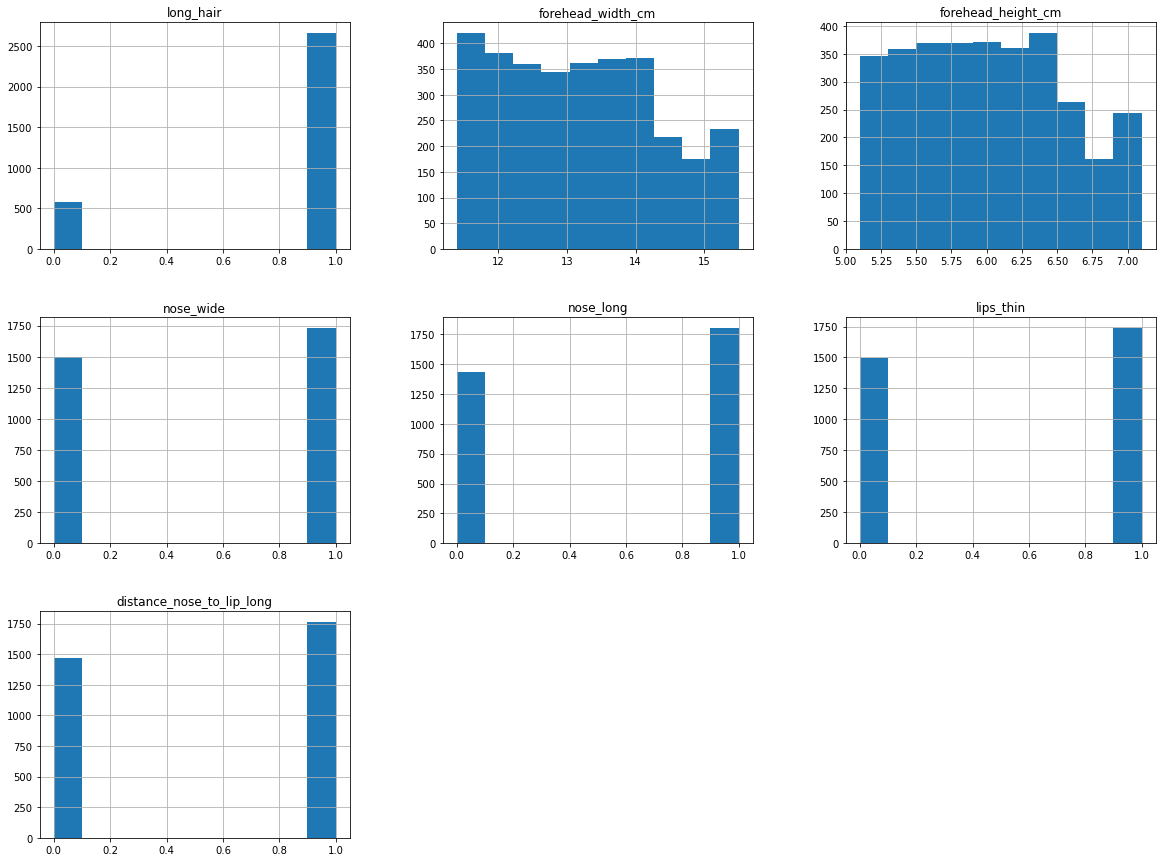

In [11]:
plot = df[feature_cols]
plot.hist(figsize=(20,15));

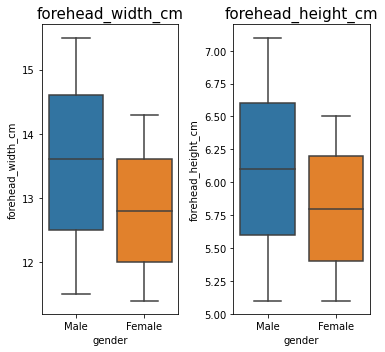

In [12]:
plt.figure(figsize = (8, 5))
for i in range(len(num_cols)):
    plt.subplot(len(num_cols)//3+1, 3, i + 1)
    sns.boxplot(y = df[num_cols[i]], x = df['gender'])
    plt.title(num_cols[i], fontsize = 15)
plt.tight_layout()
plt.show()

rata-rata dahi laki laki lebih lebar dan panjang dari pada perempuan

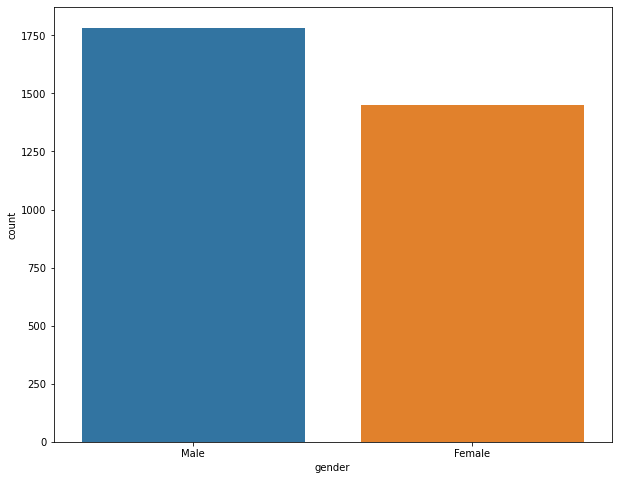

In [13]:
plt.figure(figsize=(10,8))
ax = sns.countplot(
    x = df["gender"]
)
plt.show()

Data antar gender balance

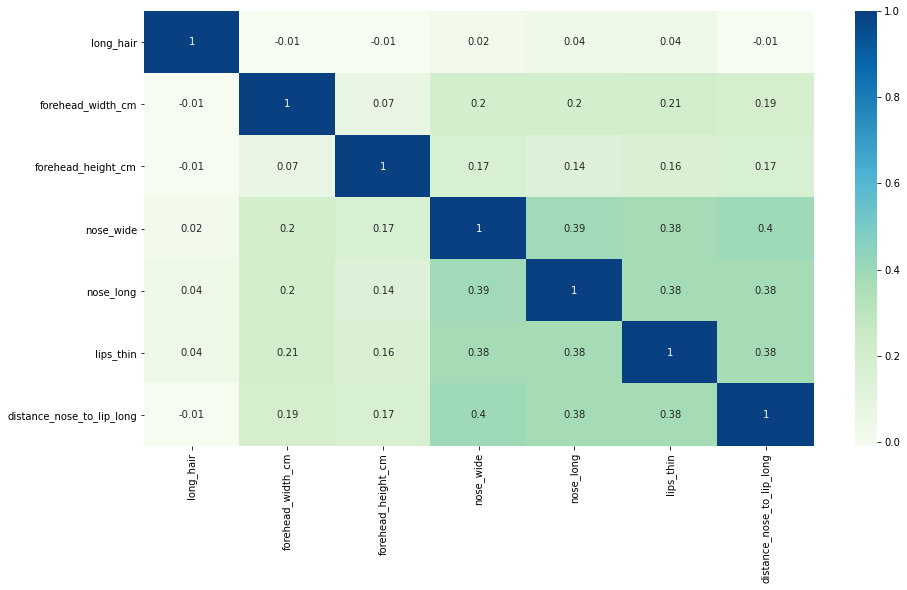

In [14]:
plt.figure(figsize=(15, 8))
sns.heatmap(round(df[feature_cols].corr(method='spearman'), 2), 
            annot=True, mask=None, cmap='GnBu')
plt.show()

# Preprocessing

In [15]:
X = df[feature_cols]
y = df[cat_cols]

## Split Data

In [16]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y, test_size=0.2)

## Scaling

In [17]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler()

In [18]:
X_train_trf = scaler.transform(X_train)

# Pipeline

## Modeling

In [19]:
logreg = LogisticRegression()
svm = SVC()
clf = DecisionTreeClassifier()
rf = RandomForestClassifier()

In [20]:
from sklearn.pipeline import Pipeline
pipe_dict={}
pipe_dict['LogisticRegression'] = Pipeline([("scaler",  StandardScaler()), ("lg", logreg)])
pipe_dict['SVM'] = Pipeline([("scaler2",  StandardScaler()), ("svm", svm)])
pipe_dict['DecisionTreeClf'] = Pipeline([("scaler3",  StandardScaler()), ("clf",clf)])
pipe_dict['RandomForestClassifier'] = Pipeline([("scaler4",  StandardScaler()), ("rf",rf)])

## Training Model

In [21]:
for model_name,model in pipe_dict.items():
    print(f"Training model {model_name}")
    %time model.fit(X_train_trf, y_train)

Training model LogisticRegression
Wall time: 9.76 ms
Training model SVM
Wall time: 56.6 ms
Training model DecisionTreeClf
Wall time: 5.86 ms
Training model RandomForestClassifier
Wall time: 180 ms


# Model Evaluation

## Confusion Matrix

In [22]:
from sklearn.metrics import confusion_matrix
for model_name,model in pipe_dict.items():
    model.fit(X_train,y_train)
    pred = model.predict(X_test)
    confusion = confusion_matrix(y_test, pred)
    print(f"Confusion matrix {model_name}:")
    print(confusion)

Confusion matrix LogisticRegression:
[[268  22]
 [ 15 342]]
Confusion matrix SVM:
[[276  14]
 [ 12 345]]
Confusion matrix DecisionTreeClf:
[[264  26]
 [ 19 338]]
Confusion matrix RandomForestClassifier:
[[269  21]
 [ 10 347]]


FN dan FP pada setiap model tidak telalu banyak, berarti model sudah cukup baik dalam memprediksi.

## Classification Report

In [23]:
from sklearn.metrics import classification_report
for model_name,model in pipe_dict.items():
    model.fit(X_train,y_train)
    pred = model.predict(X_test)
    print(f"Classification report model :  {model_name}")
    print(classification_report(y_test, pred))

Classification report model :  LogisticRegression
              precision    recall  f1-score   support

      Female       0.95      0.92      0.94       290
        Male       0.94      0.96      0.95       357

    accuracy                           0.94       647
   macro avg       0.94      0.94      0.94       647
weighted avg       0.94      0.94      0.94       647

Classification report model :  SVM
              precision    recall  f1-score   support

      Female       0.96      0.95      0.96       290
        Male       0.96      0.97      0.96       357

    accuracy                           0.96       647
   macro avg       0.96      0.96      0.96       647
weighted avg       0.96      0.96      0.96       647

Classification report model :  DecisionTreeClf
              precision    recall  f1-score   support

      Female       0.94      0.92      0.93       290
        Male       0.94      0.95      0.94       357

    accuracy                           0.94       

## Cross-Validation with kfold

In [24]:
from sklearn.model_selection import KFold
kfold = KFold(n_splits=5)

In [25]:
for model_name,model in pipe_dict.items():
    scores = cross_val_score(model,X_test, y_test,cv=kfold)
    print(f"Name model {model_name}")
    print("Cross-validation scores: {}".format(scores.mean()))

Name model LogisticRegression
Cross-validation scores: 0.9473941562313655
Name model SVM
Cross-validation scores: 0.9443291592128802
Name model DecisionTreeClf
Cross-validation scores: 0.933536076326774
Name model RandomForestClassifier
Cross-validation scores: 0.9536195587358378


## Leave-One-Out Cross-Validation

In [26]:
from sklearn.model_selection import LeaveOneOut
loo = LeaveOneOut()
for model_name,model in pipe_dict.items():
    scores = cross_val_score(model,X_test,y_test,cv=loo)
    print(f"Name model {model_name}")
    print("Cross-validation scores: {}".format(scores.mean()))

Name model LogisticRegression
Cross-validation scores: 0.9505409582689336
Name model SVM
Cross-validation scores: 0.9428129829984544
Name model DecisionTreeClf
Cross-validation scores: 0.9412673879443586
Name model RandomForestClassifier
Cross-validation scores: 0.9629057187017002


In [27]:
for model_name,model in pipe_dict.items():
    print(f"Name model {model_name}")
    print("Test score: {:.2f}".format(model.score(X_test, y_test)))

Name model LogisticRegression
Test score: 0.94
Name model SVM
Test score: 0.96
Name model DecisionTreeClf
Test score: 0.94
Name model RandomForestClassifier
Test score: 0.96


# Model Improvment

In [28]:
#parameter untuk masing masing model
param_lr = {'lg__solver':['sag','liblinear','saga','lbfgs'],
           'lg__C': [0.001, 0.01, 0.1, 1, 10, 100],
           'lg__intercept_scaling': [0.001, 0.01, 0.1, 1, 10, 100]}
param_svm = {'svm__C': [0.001, 0.01, 0.1, 1, 10, 100],
              'svm__gamma': [0.001, 0.01, 0.1, 1, 10, 100]}
param_clf = {'clf__min_samples_split': [1,2,3,4,5],
            'clf__splitter':['random','best']}
param_rf = {'rf__criterion':['gini','entropy'],
           'rf__min_samples_split': [2,3,4,5]}

In [29]:
grid_lr = GridSearchCV(pipe_dict['LogisticRegression'], param_grid=param_lr, cv=5)
grid_lr.fit(X_train, y_train)
print("Best cross-validation accuracy: {:.2f}".format(grid_lr.best_score_))
print("Test set score: {:.2f}".format(grid_lr.score(X_test, y_test)))
print("Best parameters: {}".format(grid_lr.best_params_))

Best cross-validation accuracy: 0.95
Test set score: 0.95
Best parameters: {'lg__C': 0.01, 'lg__intercept_scaling': 1, 'lg__solver': 'liblinear'}


In [30]:
grid_svm = GridSearchCV(pipe_dict['SVM'], param_grid=param_svm, cv=5)
grid_svm.fit(X_train, y_train)
print("Best cross-validation accuracy: {:.2f}".format(grid_svm.best_score_))
print("Test set score: {:.2f}".format(grid_svm.score(X_test, y_test)))
print("Best parameters: {}".format(grid_svm.best_params_))

Best cross-validation accuracy: 0.96
Test set score: 0.96
Best parameters: {'svm__C': 100, 'svm__gamma': 0.01}


In [31]:
grid_clf = GridSearchCV(pipe_dict['DecisionTreeClf'], param_grid=param_clf, cv=5)
grid_clf.fit(X_train, y_train)
print("Best cross-validation accuracy: {:.2f}".format(grid_clf.best_score_))
print("Test set score: {:.2f}".format(grid_clf.score(X_test, y_test)))
print("Best parameters: {}".format(grid_clf.best_params_))

Best cross-validation accuracy: 0.95
Test set score: 0.94
Best parameters: {'clf__min_samples_split': 5, 'clf__splitter': 'best'}


In [32]:
grid_rf = GridSearchCV(pipe_dict['RandomForestClassifier'], param_grid=param_rf, cv=5)
grid_rf.fit(X_train, y_train)
print("Best cross-validation accuracy: {:.2f}".format(grid_clf.best_score_))
print("Test set score: {:.2f}".format(grid_rf.score(X_test, y_test)))
print("Best parameters: {}".format(grid_rf.best_params_))

Best cross-validation accuracy: 0.95
Test set score: 0.96
Best parameters: {'rf__criterion': 'gini', 'rf__min_samples_split': 5}


# Model Inference

In [33]:
X_train.head(1)

,long_hair,forehead_width_cm,forehead_height_cm,nose_wide,nose_long,lips_thin,distance_nose_to_lip_long
3315,1,14.1,5.8,1,0,1,1


In [34]:
new_data = [[0,15.7,5.2,1,1,1,0],
            [0,15.5,6.2,0,0,1,0]
           ]
new_data_scaled = scaler.transform(new_data)

In [35]:
y_predict_lr = pipe_dict['LogisticRegression'].predict(new_data_scaled)
print(y_predict_lr)

['Female' 'Female']


In [36]:
y_predict_svm = pipe_dict['SVM'].predict(new_data_scaled)
print(y_predict_svm)

['Male' 'Male']


In [37]:
y_predict_clf = pipe_dict['DecisionTreeClf'].predict(new_data_scaled)
print(y_predict_clf)

['Female' 'Female']


In [38]:
y_predict_clf = pipe_dict['RandomForestClassifier'].predict(new_data_scaled)
print(y_predict_clf)

['Male' 'Female']


# Model Analysis

## Parameter Optimal untuk masing masing model

1. LogisticRegression: Pada model ini parameter yang paling optimal adalah solver:'liblinear', C:'0,01',dan intercept_scaling:'1'.
2. SVM: Pada model ini parameter yang paling optimal adalah gamma:'0,01'dan C:'100'.
3. DecisionTreeClassifier: Pada model ini parameter yang paling optimal adalah min_samples_split:'5'dan Spliter:'best'.
4. RandomForestClassifier: Pada model ini parameter yang paling optimal adalah min_samples_split:'3'dan Criterion:'gini'.

## Model paling optimal

Menurut saya, Model SVM cukup optimal dibandingkan 3 model yang lain. Karna accuracynya mencapai 96% dan score test nya mencapai 96%. Tetapi modelnya juga butuh parameter yang tepat agar mendapatkan hasil yang optimal. Kekurangan model svm adalah training model yang lebih lama dibandingkan 3 model lainnya.